# Weak lensing – Notebook 15th February 2024

Notebook tested with commit nb `9e1619f26dc2269a65c811701127a69d71710dec`.

Check requirements in `env.yml` (conda virtual environment).

In [2]:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

In [3]:
import weaklensing.utils as wlutils
import weaklensing.kappatng as wlktng
import weaklensing.cosmos as wlcosmos

## 2024-02-16

### Conformal predictions on small calibration sets

I will test calibration with the minimal number of calibration examples (such that the adjusted quantile remains below 1), to see what happens. Do the theoretical guarantees hold?

In [4]:
width = wlktng.WIDTH
size = wlktng.SIZE
print(f"Nb of pixels per side = {width}")
print(f"Opening angle = {size:.2f} deg")

Nb of pixels per side = 360
Opening angle = 1.76 deg


Load kappaTNG dataset

In [5]:
index_redshift = 2
ninpimgs = 20 # keep it small
kappa = wlktng.kappa_tng(index_redshift, ninpimgs, width=width)

Load data from the COSMOS catalog

In [6]:
data_cosmos = wlcosmos.get_data_from_cosmos(
    wlcosmos.cosmos_catalog(), size
)
extent = data_cosmos["extent"]
cosmos_mask, ra, dec = wlcosmos.cosmos_boundaries(extent, width)

In [7]:
shapedisp1, shapedisp2 = data_cosmos["shapedisp"]
shapedisp = (shapedisp1 + shapedisp2) / 2

print(f"Shape dispersion 1 = {shapedisp1:.3f}")
print(f"Shape dispersion 2 = {shapedisp2:.3f}")

Shape dispersion 1 = 0.305
Shape dispersion 2 = 0.306


In [8]:
resolution = wlutils.get_resolution(width, size)
print(f"Resolution = {resolution:.2f} arcmin/pixel")

Resolution = 0.29 arcmin/pixel


Map of number of galaxies per pixel

In [9]:
ngal = wlutils.ngal_per_pixel(data_cosmos["ra"], data_cosmos["dec"], width, extent)

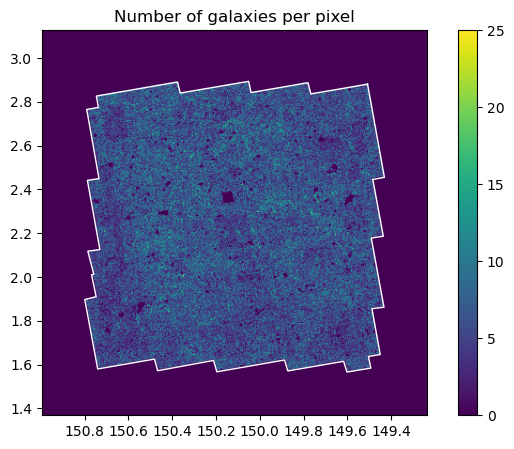

In [10]:
plt.figure(figsize=(8, 5))
plt.imshow(ngal, origin='lower', extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='w', lw=1)
plt.title("Number of galaxies per pixel")
plt.show()

Create noisy shear maps

In [11]:
gamma1, gamma2 = wlutils.get_shear_from_convergence(kappa)
gamma1_noisy, gamma2_noisy, std_noise = wlutils.get_masked_and_noisy_shear(
    gamma1, gamma2, ngal, shapedisp
)

/home/leterme231/OneDrive/Documents/Code/weaklensing/weaklensing/utils.py:120: RuntimeWarning: divide by zero encountered in divide
  shapedisp / np.sqrt(ngal), posinf=stdnoise_mask


In [12]:
confidence = 1 # Level of confidence (n-sigma)
alpha = wlutils.get_alpha_from_confidence(confidence)

min_nimgs_calib = wlutils.get_min_nimgs_calib(alpha)
print(f"Confidence level of {confidence}-sigma --> alpha = {alpha:.1%}")
print(f"Smallest possible size for the calibration set = {min_nimgs_calib}")

Confidence level of 1-sigma --> alpha = 31.7%
Smallest possible size for the calibration set = 3


In [13]:
nimgs_calib = min_nimgs_calib

Kaiser-Squires inversion

In [14]:
kappa_ks, kappa_ks_lo, kappa_ks_hi = wlutils.ksfilter(
    gamma1_noisy, gamma2_noisy, std_noise, confidence
)

Split test and calibration sets

In [15]:
[kappa_ks_lo_calib, kappa_ks_hi_calib, kappa_calib], [kappa_ks_lo_test, kappa_ks_hi_test, kappa_test] = \
    wlutils.split_test_calib(
        [kappa_ks_lo, kappa_ks_hi, kappa], nimgs_calib
    )
print(f"Size of the calibration set = {kappa_calib.shape[0]}")
print(f"Size of the test set = {kappa_test.shape[0]}")

Size of the calibration set = 3
Size of the test set = 177


Conformalize

In [16]:
kappa_ks_lo_cqr_test, kappa_ks_hi_cqr_test, quantile_vals, adjusted_quantile = wlutils.conformalize(
    kappa_ks_lo_test, kappa_ks_hi_test, kappa_ks_lo_calib, kappa_ks_hi_calib,
    kappa_calib, alpha
)

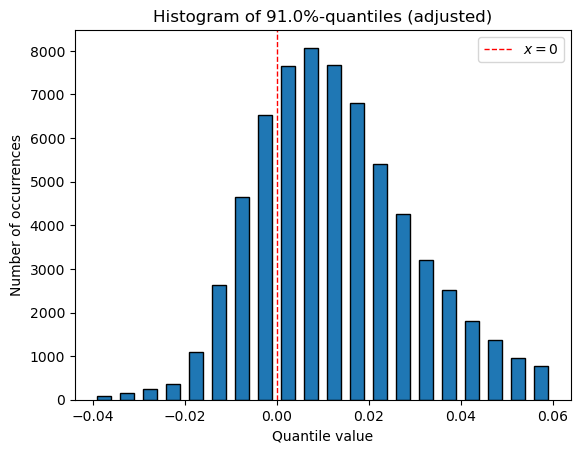

In [17]:
quantile_vals_filtered = quantile_vals[cosmos_mask] # we only consider the quantiles inside of the COSMOS field boundaries
qmin, qmax = -0.04, 0.06
nbins = 20
bins = np.linspace(qmin, qmax, nbins+1)
plt.hist(
    quantile_vals_filtered, bins=bins, edgecolor='black', align='mid', rwidth=0.6
)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=1., label=r'$x = 0$')
plt.xlabel('Quantile value')
plt.ylabel('Number of occurrences')
plt.legend()
plt.title(f'Histogram of {adjusted_quantile:.1%}-quantiles (adjusted)')
plt.show()

Get results on the test set

In [18]:
losses_ks_test = wlutils.loss(
    kappa_ks_lo_test, kappa_ks_hi_test, kappa_test, mask=cosmos_mask
)
losses_ks_cqr_test = wlutils.loss(
    kappa_ks_lo_cqr_test, kappa_ks_hi_cqr_test, kappa_test, mask=cosmos_mask
)
lower_bound_proba, upper_bound_proba = wlutils.get_bounds_proba_cqr(
    alpha, nimgs_calib
)
mid_proba = (upper_bound_proba + lower_bound_proba) / 2
mean_loss = np.mean(losses_ks_cqr_test)

print(f"Lower bound proba = {lower_bound_proba:.1e}")
print(f"Upper bound proba = {upper_bound_proba:.1e}")
print(f"Empirical mean loss (after calibration) = {mean_loss:.1e}")

Lower bound proba = 6.7e-02
Upper bound proba = 3.2e-01
Empirical mean loss (after calibration) = 2.8e-01


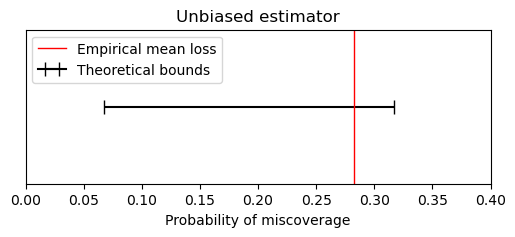

In [19]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.errorbar(
    mid_proba, 0, xerr=[[mid_proba - lower_bound_proba], [upper_bound_proba - mid_proba]],
    fmt='', color='black', capsize=5, label="Theoretical bounds"
)
ax.axvline(
    x=mean_loss, color='red', linestyle='solid', linewidth=1., label='Empirical mean loss'
)
ax.set_xlim(0., np.ceil(upper_bound_proba * 10) / 10)
ax.set_xlabel('Probability of miscoverage')
ax.set_yticks([])
plt.legend()
plt.title("Unbiased estimator")
plt.show()

Possibly very conservative.

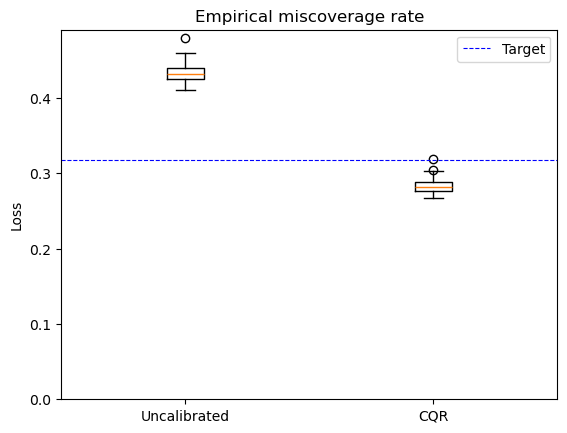

In [20]:
xticklabels = ["Uncalibrated", "CQR"]

plt.boxplot([losses_ks_test, losses_ks_cqr_test])
plt.ylim(bottom=0.)
plt.xticks([1, 2], xticklabels)
plt.ylabel("Loss")
plt.axhline(y=alpha, color='blue', linestyle='--', linewidth=0.8, label='Target')
plt.legend()
plt.title(r"Empirical miscoverage rate")
plt.show()

## 2024-02-19

To test the sensitivity of the results with respect to the calibration set, I will run the calibration several times with various test/calibration set splits. This time, I will consider each pixel as its own regression problem, and compute, for each test/calibration set split and each pixel, the error rate. Then, I will compute the empirical estimate of the statistical series $\{E_k\}_{k \in \{1,\, \dots,\, K\}}$ over the test set, with
$$
    E_k := \mathbb P\left\{
        \boldsymbol\kappa[k] \notin \left[
            \hat{\boldsymbol\kappa}^-[k],\, \hat{\boldsymbol\kappa}^+[k]
        \right] \middle| \left\{\hat{\boldsymbol\gamma}_i,\,\boldsymbol\kappa_i\right\}_{i \in \{1,\, \dots,\, n\}}
    \right\},
$$
where $\left\{\hat{\boldsymbol\gamma}_i,\,\boldsymbol\kappa_i\right\}_{i \in \{1,\, \dots,\, n\}}$ denotes a calibration set. The theory states that $\mathbb E[E_k] \in \left[\alpha - \frac1{n+1},\, \alpha\right]$, but $E_k$ may lie outside this interval, depending on the choice of calibration set.

In [21]:
ntries = 10
idx_arr = np.arange(kappa.shape[0])
list_of_errorrates = []
for i in range(ntries):
    np.random.shuffle(idx_arr)
    kappa_ks_lo_shuff = kappa_ks_lo[idx_arr]
    kappa_ks_hi_shuff = kappa_ks_hi[idx_arr]
    kappa_shuff = kappa[idx_arr]

    # Split
    [kappa_ks_lo_shuff_calib, kappa_ks_hi_shuff_calib, kappa_shuff_calib], \
        [kappa_ks_lo_shuff_test, kappa_ks_hi_shuff_test, kappa_shuff_test] = \
            wlutils.split_test_calib(
                [kappa_ks_lo_shuff, kappa_ks_hi_shuff, kappa_shuff], nimgs_calib
            )

    # Conformalize
    kappa_ks_lo_cqr_shuff_test, kappa_ks_hi_cqr_shuff_test, _, _ = wlutils.conformalize(
        kappa_ks_lo_shuff_test, kappa_ks_hi_shuff_test, kappa_ks_lo_shuff_calib, kappa_ks_hi_shuff_calib,
        kappa_shuff_calib, alpha
    )

    # Get results on the test set
    illpredicted_ks_cqr_shuff_test = (kappa_shuff_test < kappa_ks_lo_cqr_shuff_test) | \
        (kappa_shuff_test > kappa_ks_hi_cqr_shuff_test)
    errorrates = np.mean(illpredicted_ks_cqr_shuff_test, axis=0)
    errorrates = errorrates[cosmos_mask]
    list_of_errorrates.append(errorrates)

errorrates = np.array(list_of_errorrates)
mean_errorrates = np.mean(errorrates, axis=1)

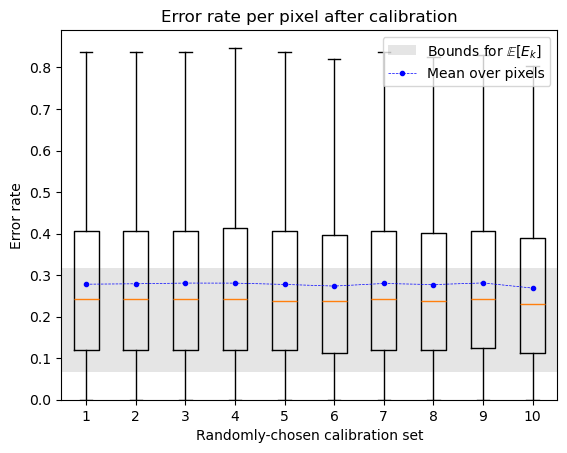

In [22]:
xticks = np.arange(ntries) + 1

plt.axhspan(
    alpha - 1 / (nimgs_calib + 1), alpha,
    color='k', alpha=0.1, linewidth=0., label=r"Bounds for $\mathbb{E}[E_k]$"
)
plt.boxplot(list_of_errorrates, showfliers=False)
plt.plot(xticks, mean_errorrates, 'b.--', linewidth=0.5, label="Mean over pixels")
plt.ylim(bottom=0.)
plt.xticks(xticks, xticks)
plt.xlabel("Randomly-chosen calibration set")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.title(r"Error rate per pixel after calibration")
plt.show()

We can see that, even with a small calibration set, the mean error rate remains within the theoretical bounds (rather closer to the upper bound than the lower bound). This is due to the large number of pixels over which we average the results. However, the expected error rate $\mathbb{E}[E_k]$ for a given pixel $k$ may lie below or above these bounds, as evidenced by the distribution of empirical estimates computed over the test set. Let's focus on a single (central) pixel.

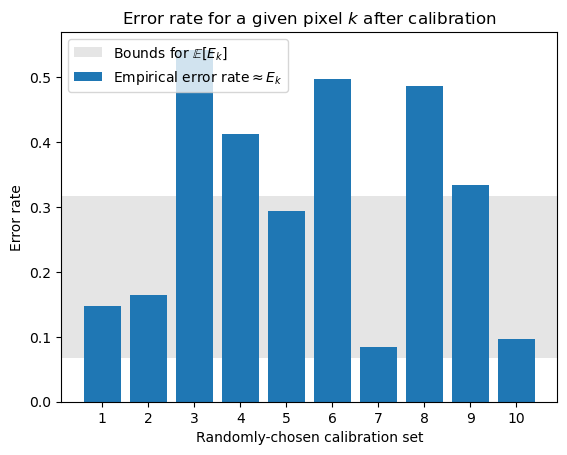

In [23]:
plt.axhspan(
    alpha - 1 / (nimgs_calib + 1), alpha,
    color='k', alpha=0.1, linewidth=0., label=r"Bounds for $\mathbb{E}[E_k]$"
)
plt.bar(xticks, errorrates[:, width * 180 + 180], label=r"Empirical error rate$\approx E_k$")
plt.ylim(bottom=0.)
plt.xticks(xticks, xticks)
plt.xlabel("Randomly-chosen calibration set")
plt.ylabel("Error rate")
plt.title(r"Error rate for a given pixel $k$ after calibration")
plt.legend()
plt.show()

The distribution of error rates per pixel has a quite large variance (which depends on the size of the calibration set), but the distribution of the mean value over a bunch of pixels is much smaller.
- [ ] **Q.** *(2024-02-19)* Is it possible to estimate this variance? We have to take into consideration the fact that the error rates $E_k$ are not independent between neighboring pixels.